In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import time

In [3]:
api = KaggleApi()
api.authenticate()
api.competition_download_files('digit-recognizer', path='./data')

dataset_path = './data'
dataset_zip = os.path.join(dataset_path, 'digit-recognizer.zip')

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

    

In [4]:
start_time = time.time()

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print("Data loaded in {:.2f} seconds".format(time.time() - start_time))

X = train.drop('label', axis=1)
y = train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split in {:.2f} seconds".format(time.time() - start_time))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data scaled in {:.2f} seconds".format(time.time() - start_time))

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA transformation done in {:.2f} seconds".format(time.time() - start_time))

param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.1, 1, 10]
}

random_search = RandomizedSearchCV(SVC(kernel='linear', probability=True), param_grid, cv=2, n_iter=2, verbose=2)
try:
    random_search.fit(X_train_pca, y_train)
except KeyboardInterrupt:
    print("Grid search interrupted by user!")
else:
    print("Grid search done in {:.2f} seconds".format(time.time() - start_time))

best_model = random_search.best_estimator_

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svm', best_model)
])

print("Pipeline created in {:.2f} seconds".format(time.time() - start_time))

Data loaded in 6.34 seconds
Data split in 7.32 seconds
Data scaled in 8.68 seconds
PCA transformation done in 10.23 seconds
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ...................................C=100, gamma=0.1; total time=13.9min
[CV] END ...................................C=100, gamma=0.1; total time=19.1min
[CV] END ......................................C=10, gamma=1; total time= 4.4min
[CV] END ......................................C=10, gamma=1; total time= 5.6min
Grid search done in 5413.34 seconds
Pipeline created in 5413.42 seconds


In [5]:
def train_model_svm():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix(y_test, y_pred), interpolation='nearest', cmap='Blues')
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.show()

    n_classes = len(np.unique(y_test))
    for i in range(n_classes):
        y_test_binary = np.where(y_test == i, 1, 0)
        auc_value = roc_auc_score(y_test_binary, y_pred_proba[:, i])
        print(f"Class {i} AUC: {auc_value:.2f}")

    for i in range(n_classes):
        y_test_binary = np.where(y_test == i, 1, 0)
        fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba[:, i])
        auc_value = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_value:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

    for i in range(n_classes):
        y_test_binary = np.where(y_test == i, 1, 0)
        precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba[:, i])
        auc_value = auc(recall, precision)
        plt.plot(recall, precision, label=f'Class {i} (AUC = {auc_value:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

In [14]:
def test_model_svm():
    print("Testing kernel SVM Model...")
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Kernel SVM model's Accuracy: {accuracy * 100:.2f}%")

    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix(y_test, y_pred), interpolation='nearest', cmap='Blues')
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.show()

    n_classes = len(np.unique(y_test))
    for i in range(n_classes):
        y_test_binary = (y_test == i).astype(int)
        y_pred_proba_binary = y_pred_proba[:, i]
        precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba_binary)
        auc_value = auc(recall, precision)
        plt.figure(figsize=(10, 8))
        plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_value)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve for Class %d' % i)
        plt.legend(loc="lower right")
        plt.show()

Accuracy: 0.9271428571428572
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       816
           1       0.95      0.99      0.97       909
           2       0.90      0.91      0.90       846
           3       0.90      0.91      0.91       937
           4       0.92      0.93      0.93       839
           5       0.88      0.90      0.89       702
           6       0.94      0.95      0.94       785
           7       0.95      0.93      0.94       893
           8       0.93      0.88      0.91       835
           9       0.94      0.90      0.92       838

    accuracy                           0.93      8400
   macro avg       0.93      0.93      0.93      8400
weighted avg       0.93      0.93      0.93      8400



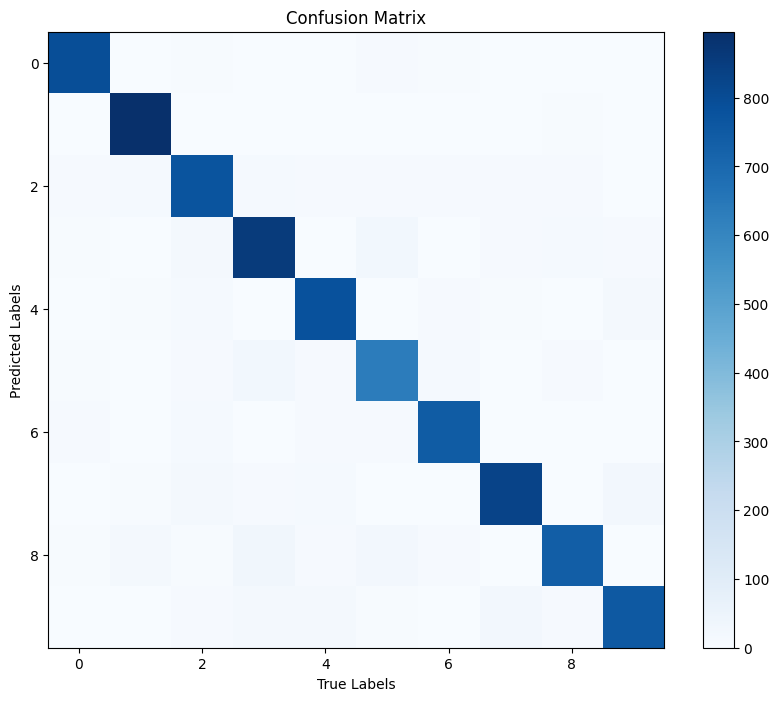

Class 0 AUC: 1.00
Class 1 AUC: 1.00
Class 2 AUC: 0.99
Class 3 AUC: 0.99
Class 4 AUC: 1.00
Class 5 AUC: 0.99
Class 6 AUC: 1.00
Class 7 AUC: 1.00
Class 8 AUC: 0.99
Class 9 AUC: 0.99


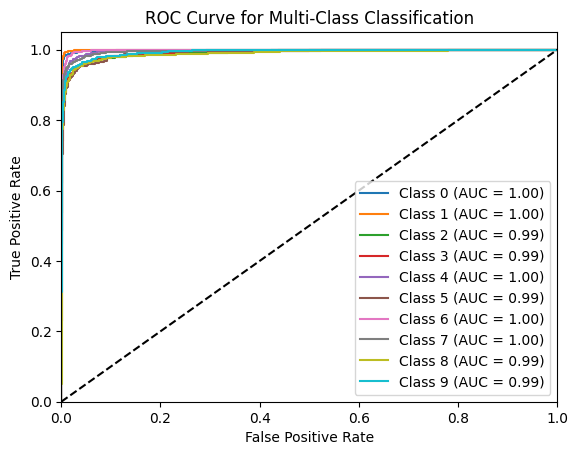

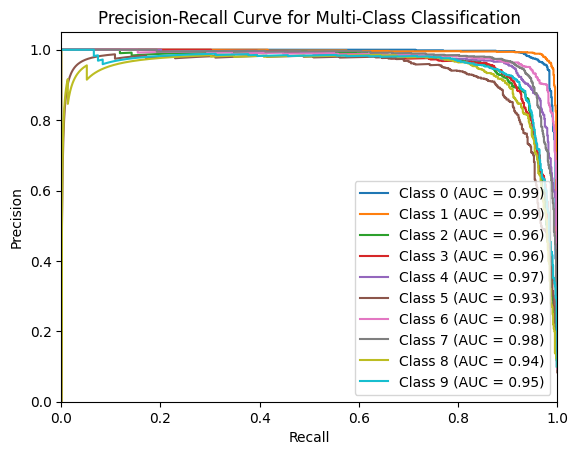

Best Parameters: {'gamma': 1, 'C': 10}
Best Score: 0.9132738095238095


In [7]:
def main():
    train_model_svm()
    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)

if __name__ == "__main__" : 
    main()

Testing kernel SVM Model...
Kernel SVM model's Accuracy: 92.71%


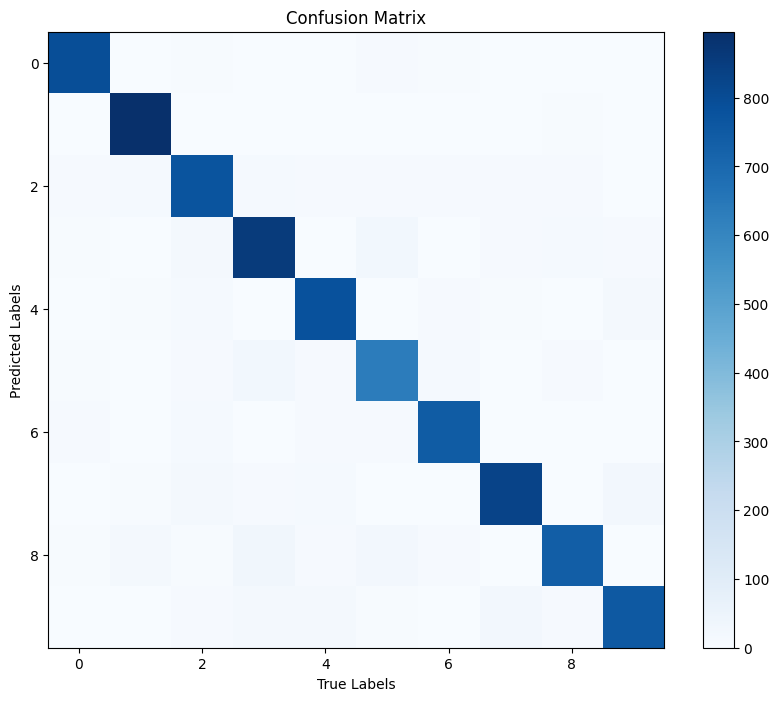

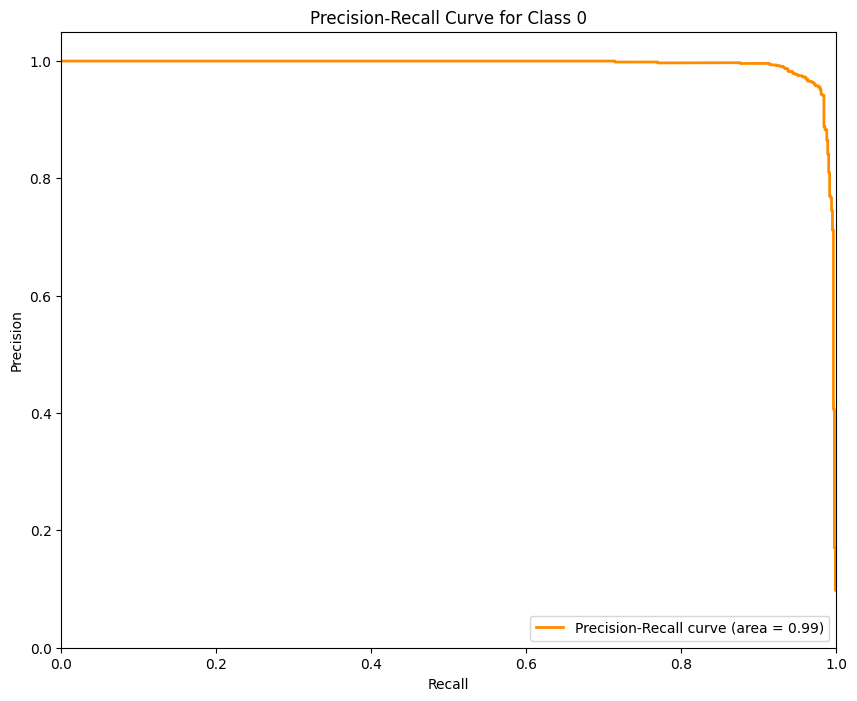

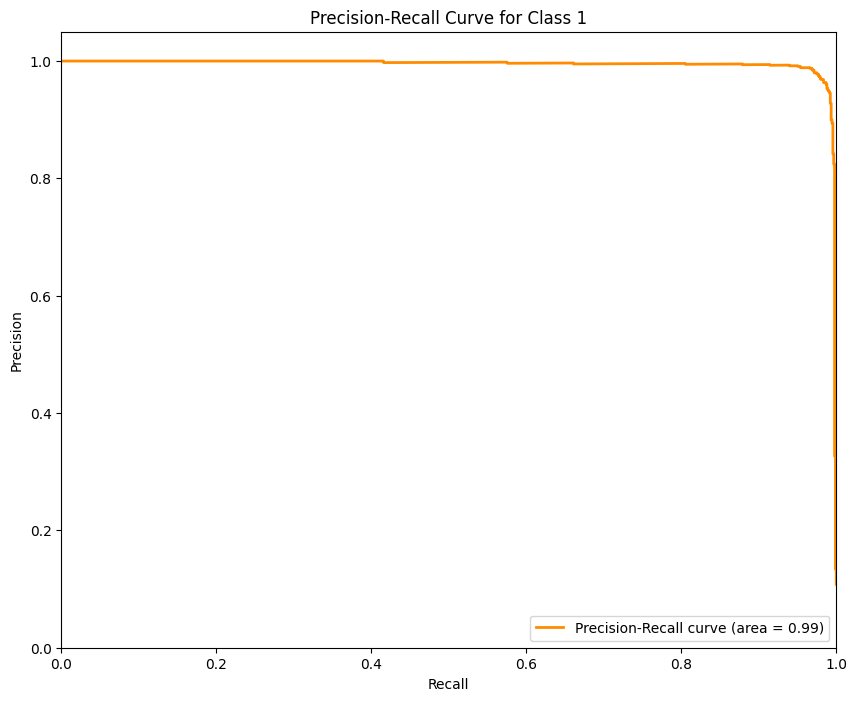

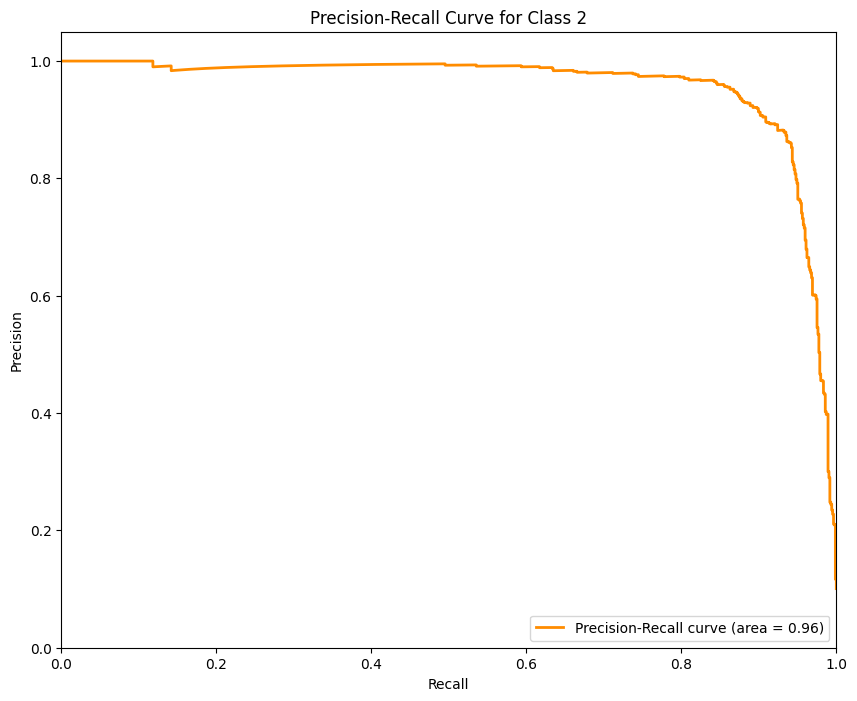

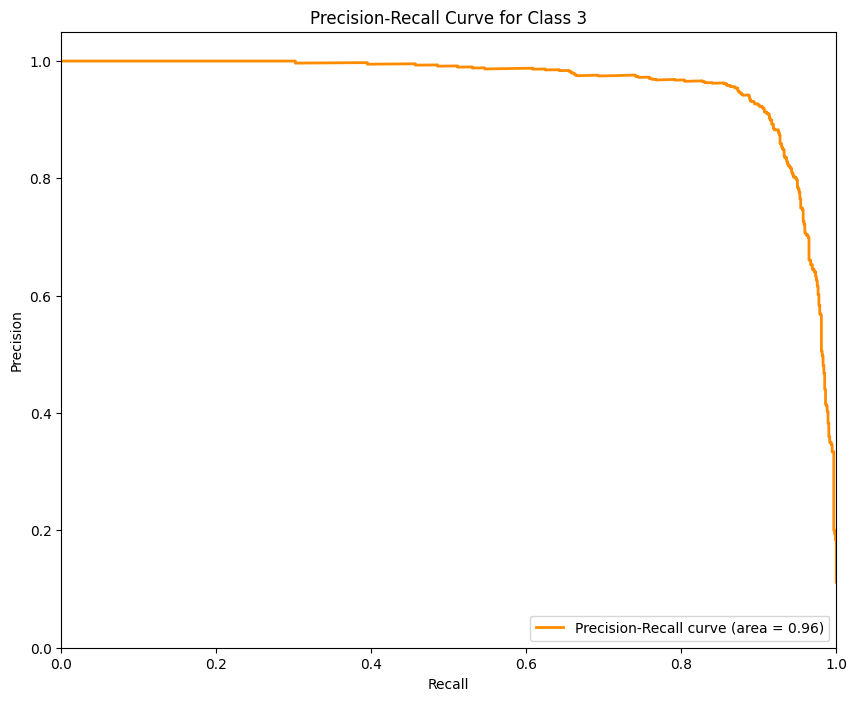

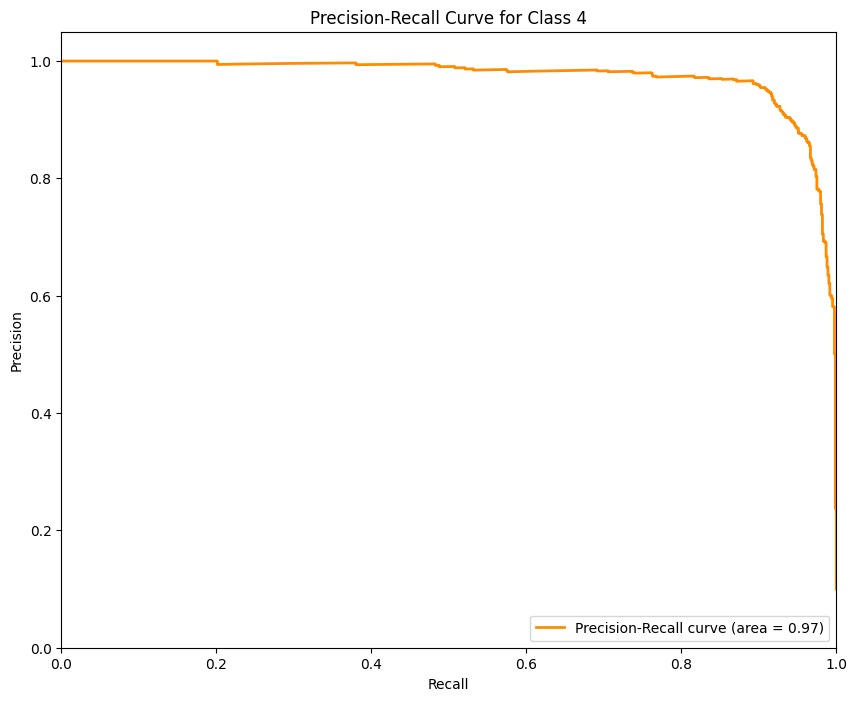

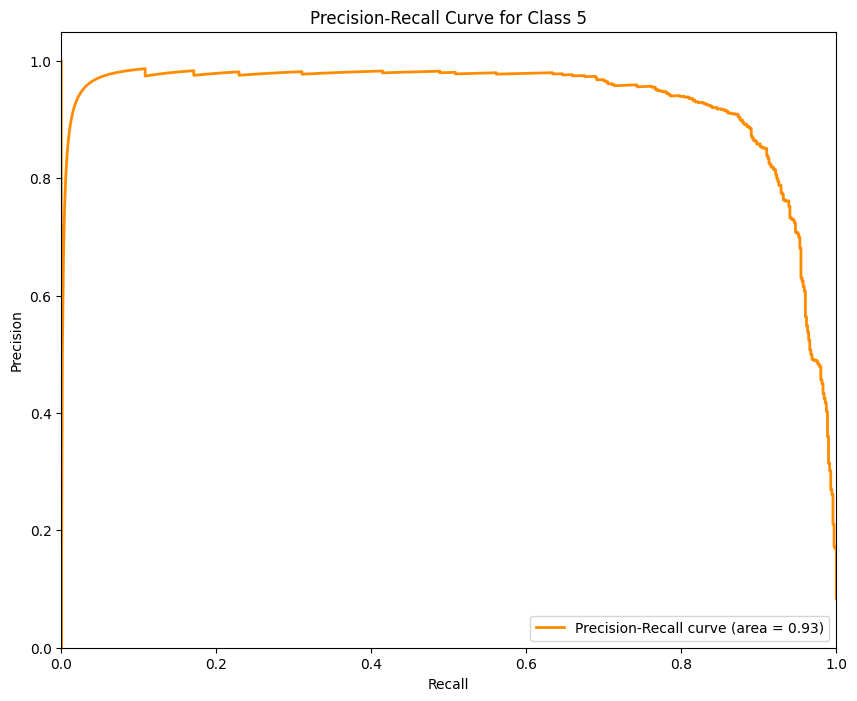

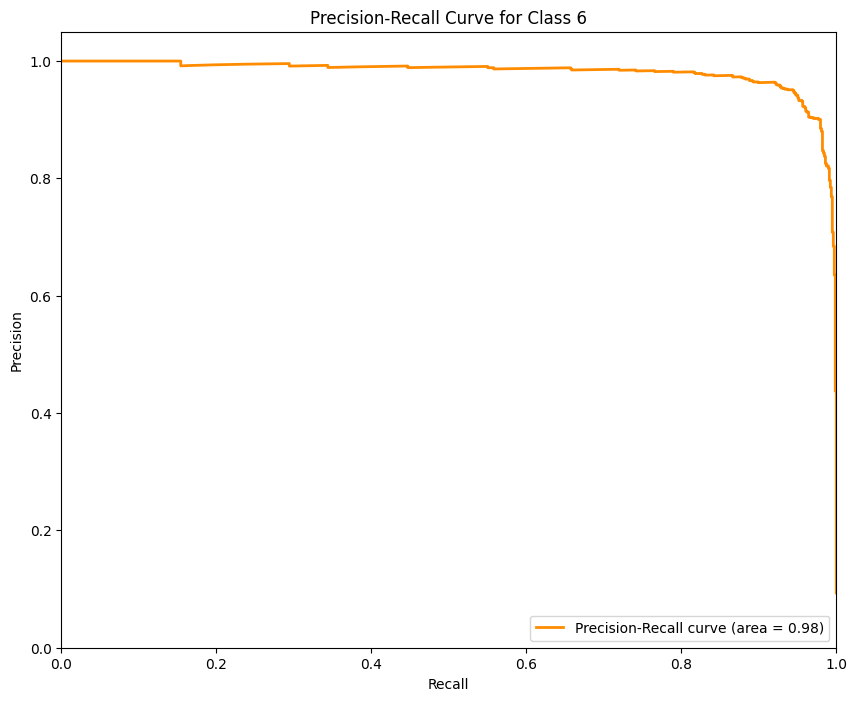

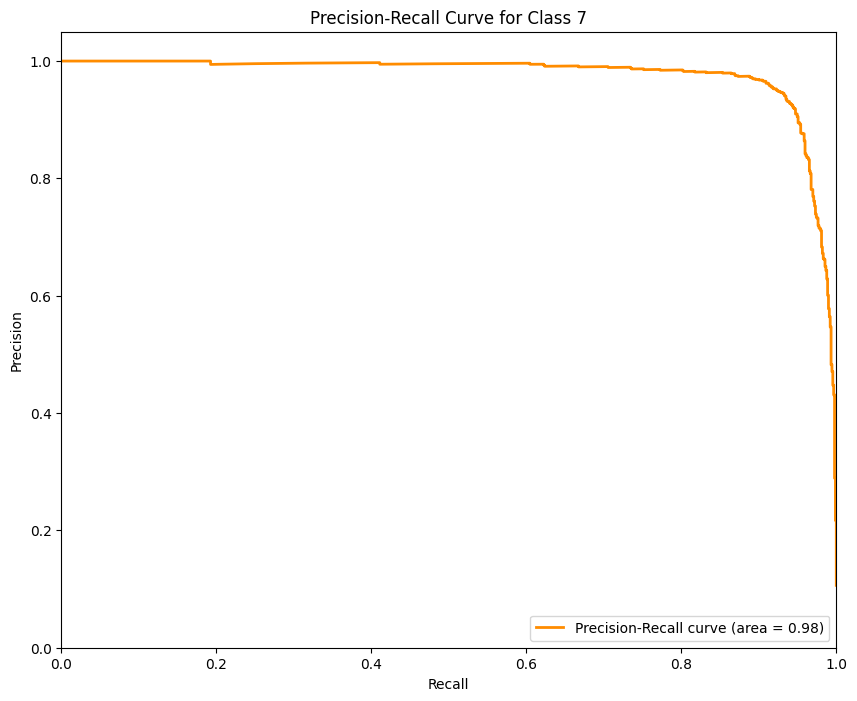

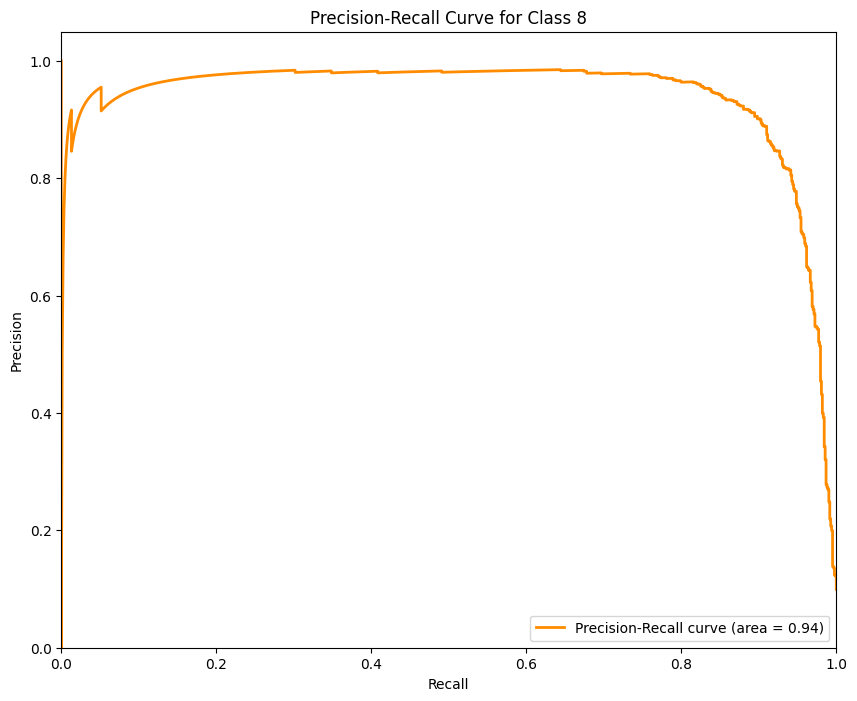

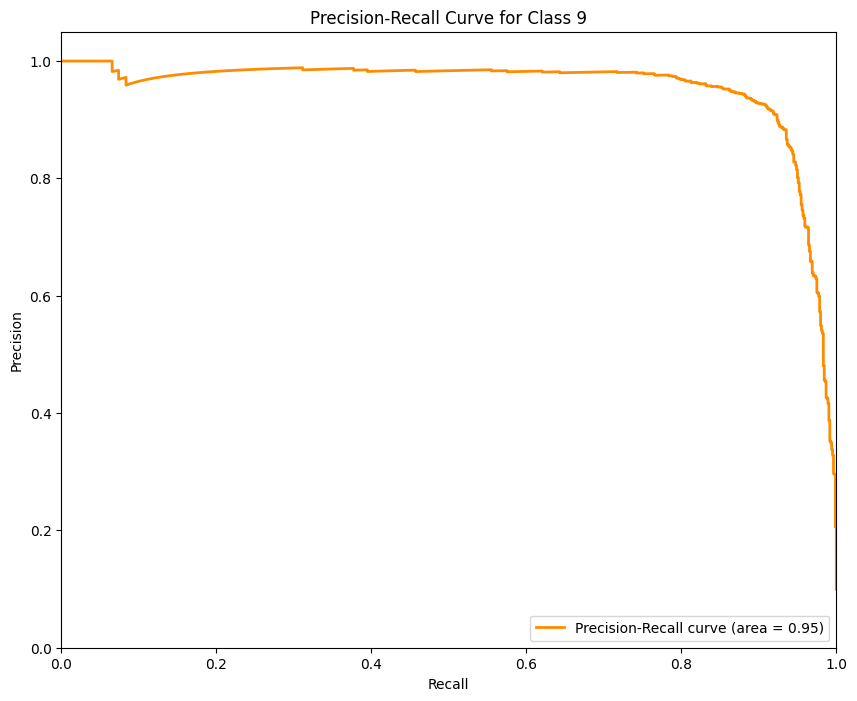

In [15]:
def main2():
    test_model_svm()

if __name__ == "__main__" : 
    main2()